# **Customer Churn Prediction**

---
This notebook aims to predict whether a customer will stop using the bank's services.


**Dataset overview:**

The data consists of 10000 observations with 12 independent variables containing information about bank's customers.

**Features:**
- Surname: Customer’s last name
- CreditScore: Customer’s credit score
- Geography: Customer’s country of residence (Germany / France / Spain)
- Gender: Customer’s gender (Female / Male)
- Age: Customer’s age in years
- Tenure: Number of years the customer has been with the bank
- Balance: Account balance amount
- NumOfProducts: Number of bank products the customer is using
- HasCrCard: Whether the customer has a credit card (0 = No, 1 = Yes)
- IsActiveMember: Whether the customer is an active member (0 = No, 1 = Yes)
- EstimatedSalary: Customer’s estimated annual salary

**Target**
- Exited: Whether the customer has churned (0 = No, 1 = Yes)

Instructions:
- Lakukan eksplorasi data. Apa saja insight yang kamu dapat?
- Lakukan data cleaning dan preprocessing yang kamu anggap dibutuhkan untuk dataset ini.
- Tentukan metric yang sesuai dengan case dataset ini. Jelaskan alasan mengapa memilih metric tersebut.
- Lakukan modeling dengan menggunakan model logistic regression, knn, decision tree, random forest, stacking, voting, adaboost, gradientboost, xgboost.
- Pilih model terbaik dan lakukan hyperparameter tuning.
- Bandingkan hasil sebelum dan sesudah tuning.
- Bandingkan cost pada skenario bisnis (menggunakan confusion matrix):
    - Sebelum menggunakan ML
    - Setelah menggunakan ML

Diketahui pada bidang perbankang:
- retention cost: $20
- acquisition cost: $100

## Import Necessary Dependencies

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt


# data splitting
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer  # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# binnind & polynomial feature
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score

# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# evaluation metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report 

# tree
from sklearn.tree import plot_tree

# GridSearchCV dan RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model Ensamble
from sklearn.ensemble import VotingClassifier, StackingClassifier

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [2]:
df = pd.read_csv('churn.csv')

## Exploratory Data Analysis (EDA)

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

It looks like our data doesn't have any duplicate or missing values

Next, we will analyze the distribution of our numerical features

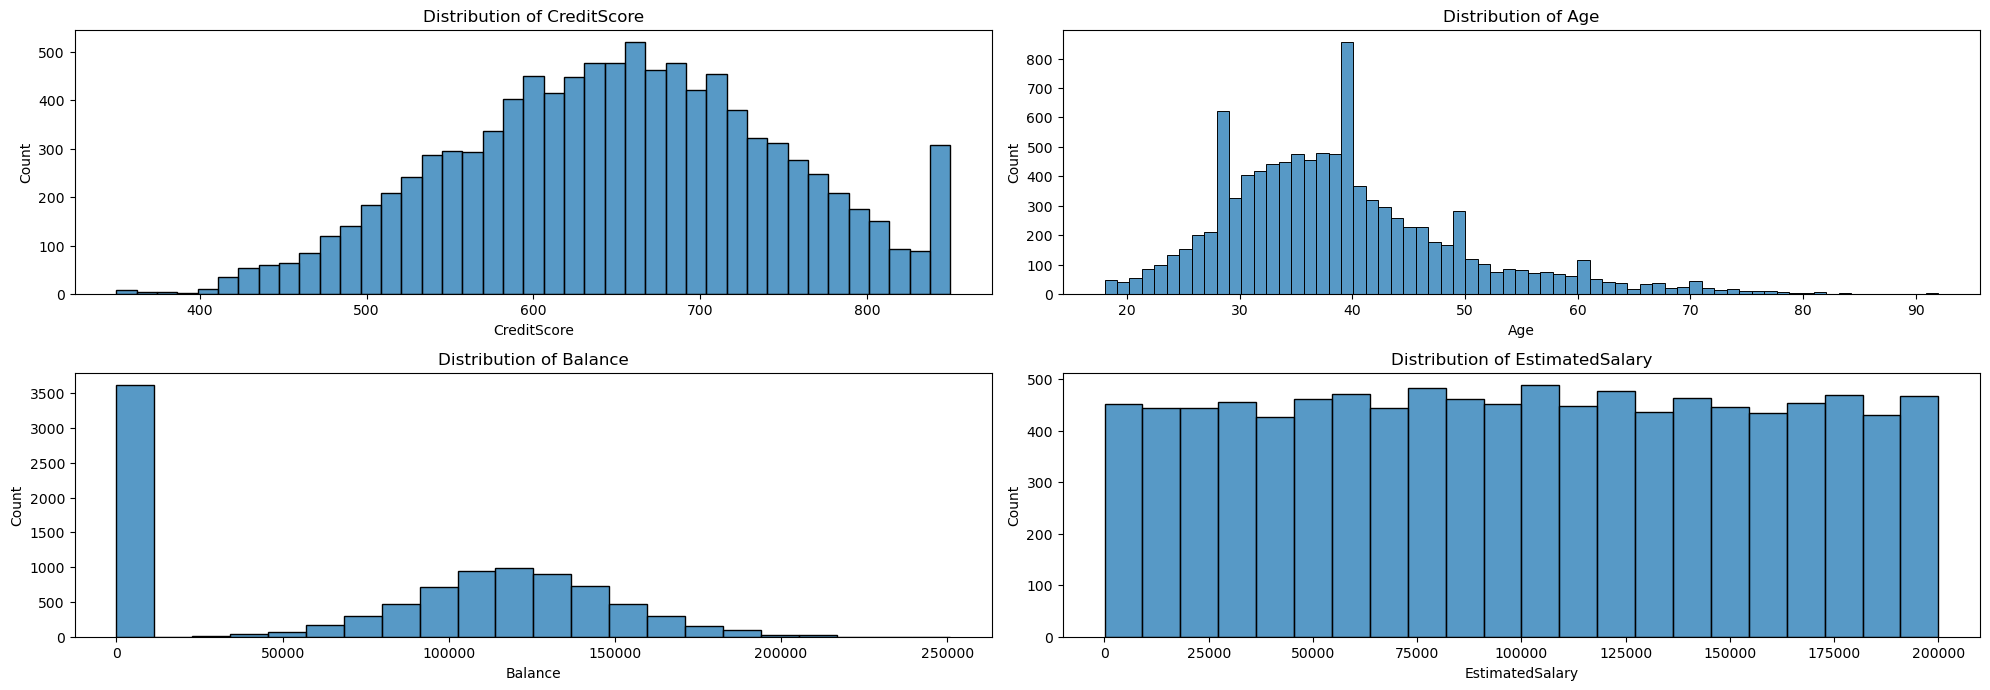

In [7]:
# Histogram numerical variables

num_col = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

plt.figure(figsize=(20, 10))

for i in range(len(num_col)):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data=df, x=num_col[i])
    plt.title(f'Distribution of {num_col[i]}')

plt.tight_layout()

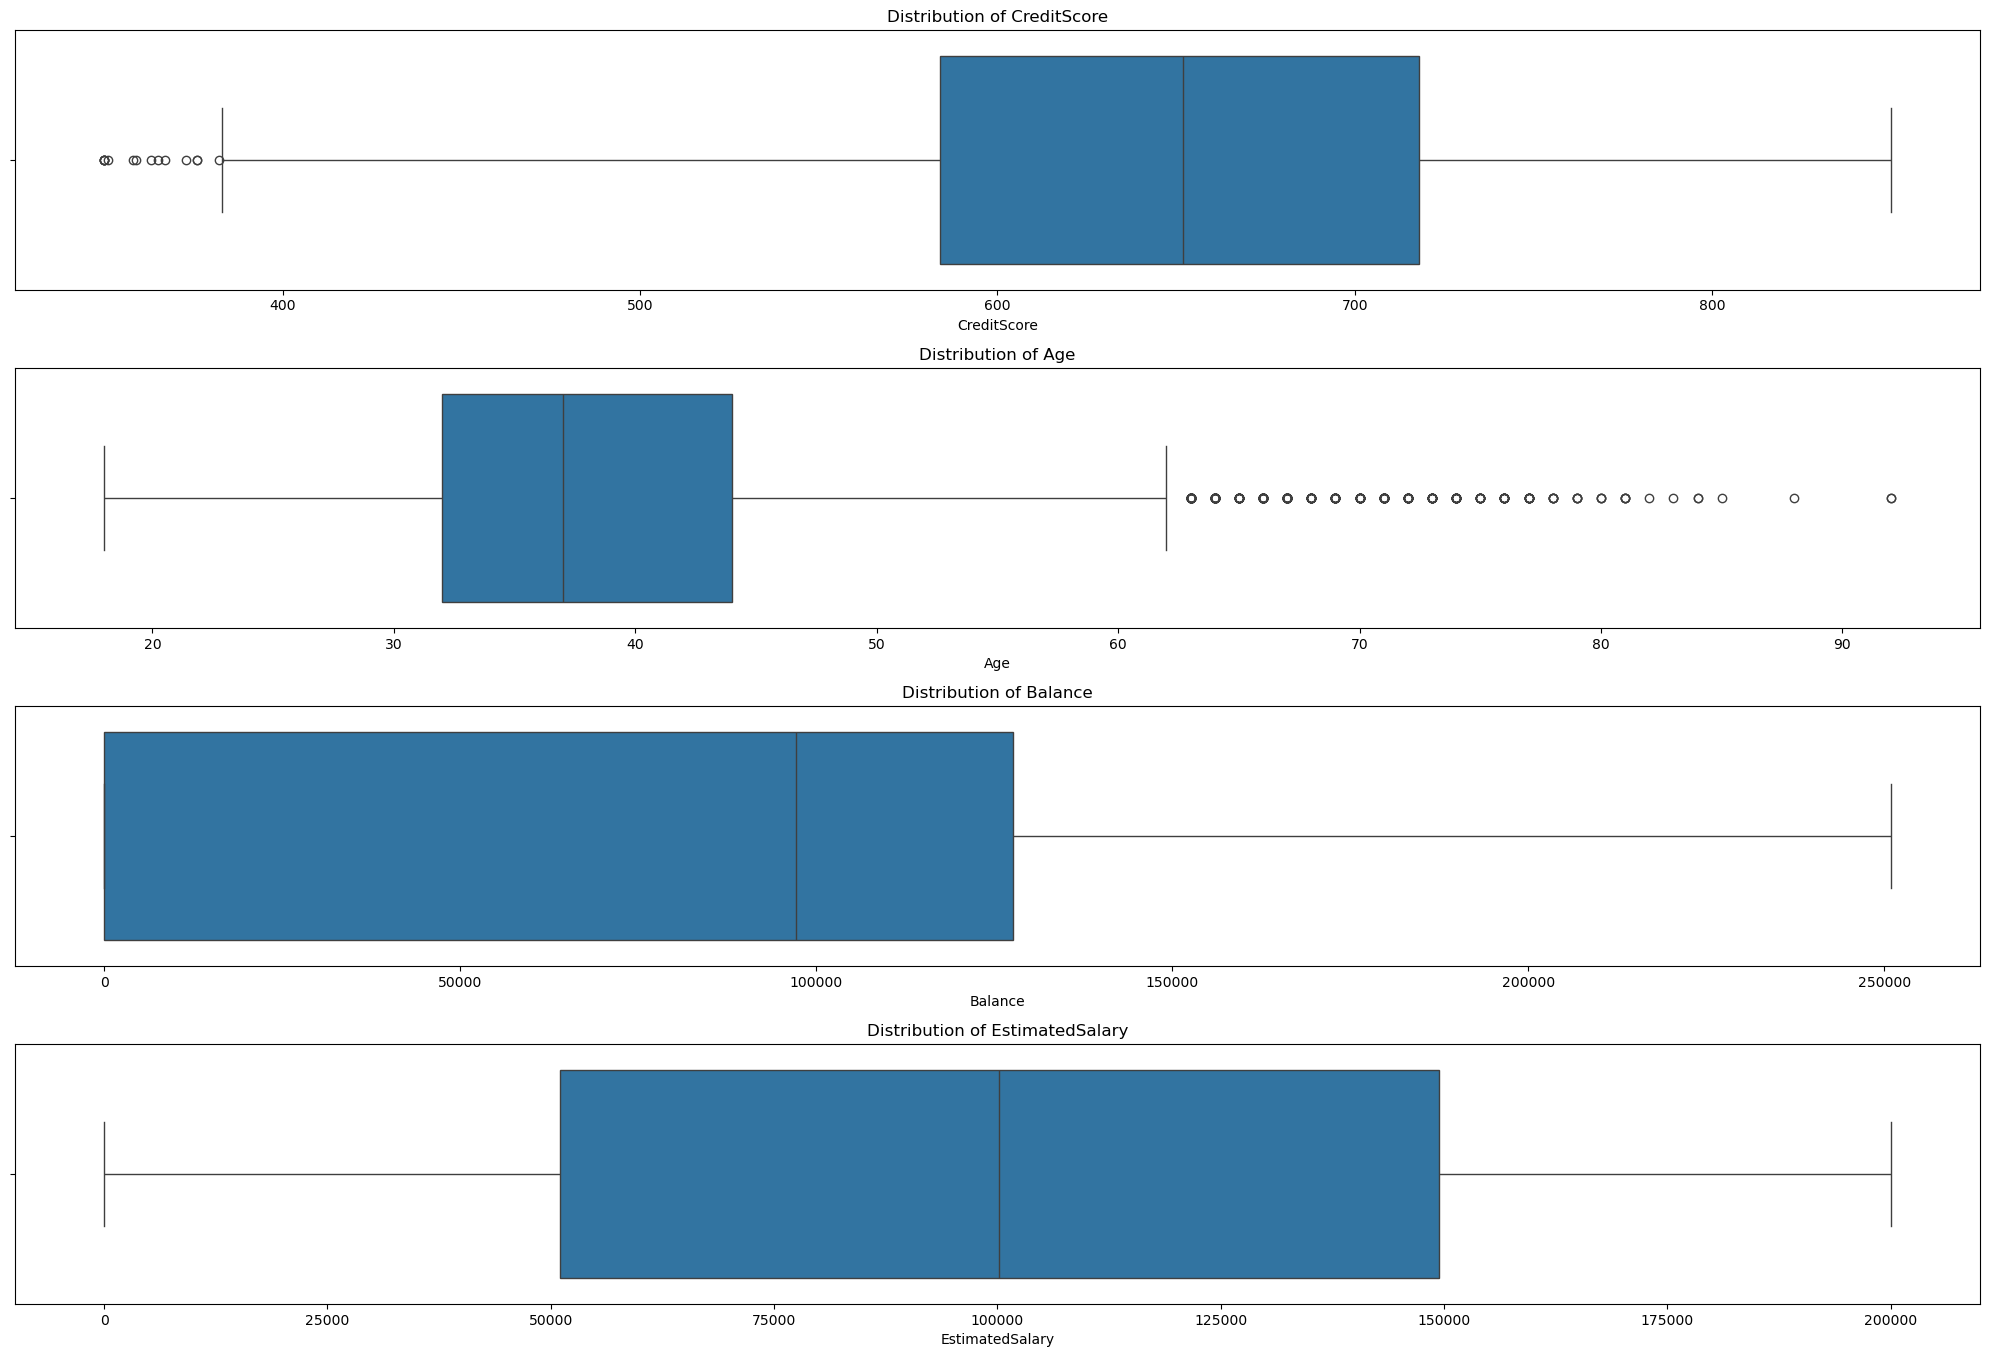

In [8]:
# Boxplot (for numerical variables)

plt.figure(figsize=(20, 20))

for i in range(len(num_col)):
    plt.subplot(6, 1, i + 1)
    sns.boxplot(data=df, x=num_col[i])
    plt.title(f'Distribution of {num_col[i]}')

plt.tight_layout()

**Insight :**

Based on the graphs above, we can conclude that none of the numerical features follow a normal distribution. Therefore, we will use a Robust Scaler during data preprocessing.

Additionally, we will remove customers older than 85 years, as they appear to be extreme outliers based on the distribution and are significantly distant from the rest of the data.

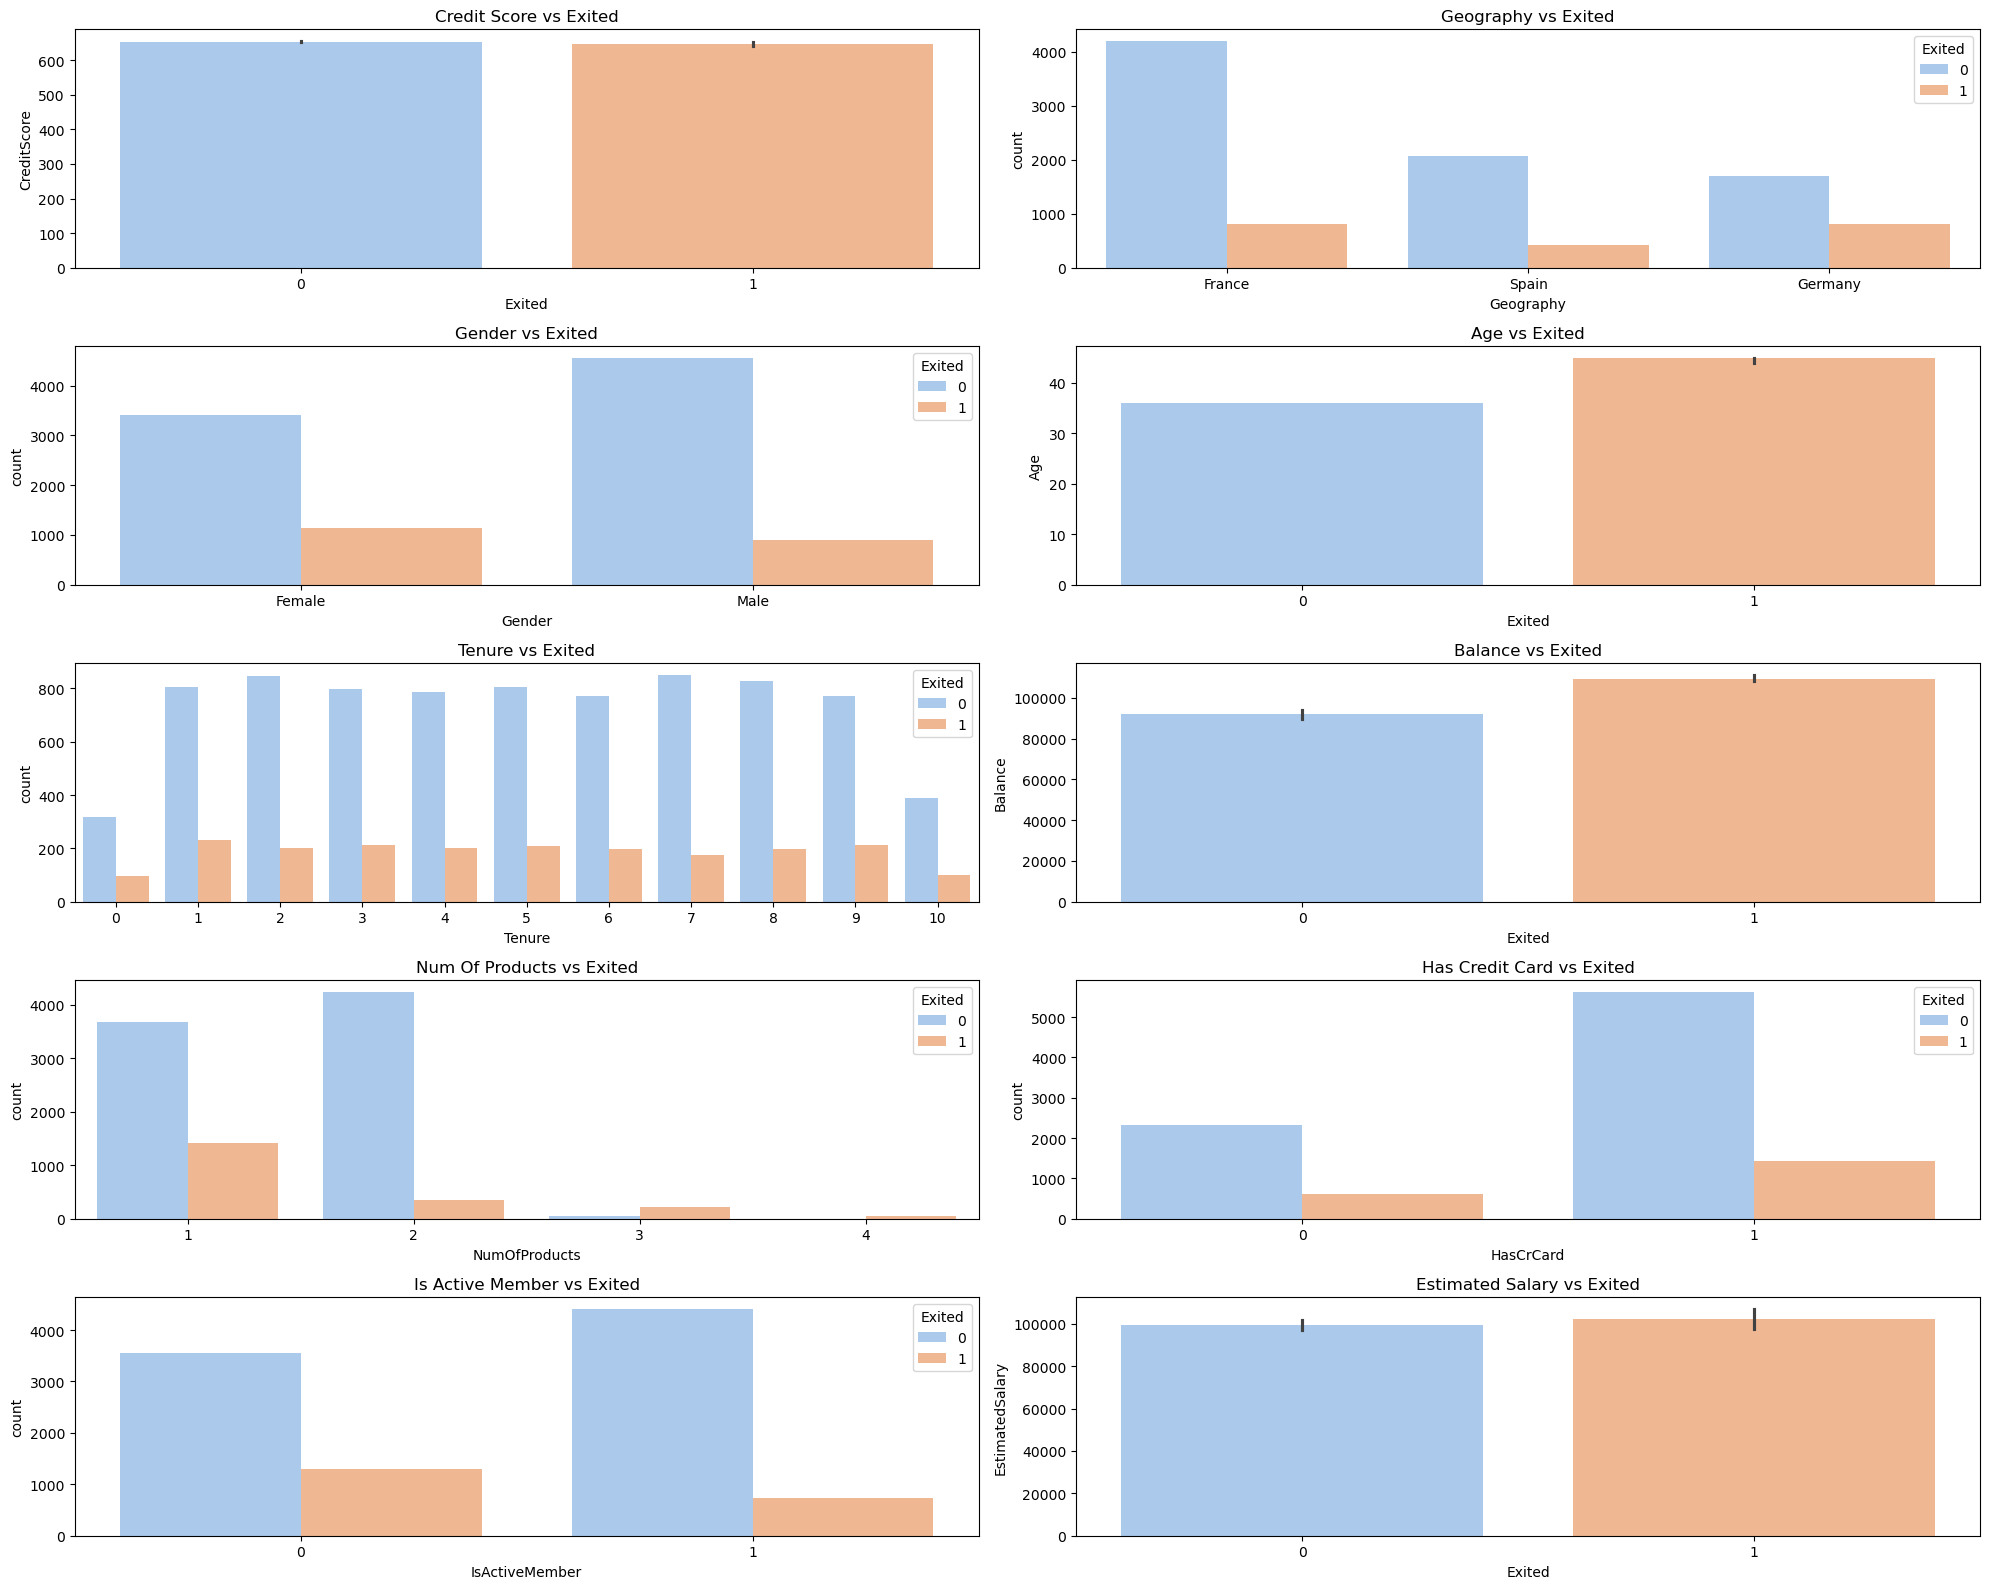

In [9]:
plt.figure(figsize=(20,16))

# Credit Score vs Exited
plt.subplot(5,2,1)
sns.barplot(data=df, x='Exited', y='CreditScore', estimator = 'median', palette = 'pastel')
plt.title('Credit Score vs Exited')

# Geography vs Exited
plt.subplot(5,2,2)
sns.countplot(data=df, x='Geography', hue = 'Exited', palette = 'pastel')
plt.title('Geography vs Exited')

# Gender vs Exited
plt.subplot(5,2,3)
sns.countplot(data=df, x='Gender', hue = 'Exited', palette = 'pastel')
plt.title('Gender vs Exited')

# Age vs Exited
plt.subplot(5,2,4)
sns.barplot(data=df, x='Exited', y='Age', estimator = 'median', palette = 'pastel')
plt.title('Age vs Exited')

# Tenure vs Exited
plt.subplot(5,2,5)
sns.countplot(data=df, x='Tenure', hue = 'Exited', palette = 'pastel')
plt.title('Tenure vs Exited')

# Balance vs Exited
plt.subplot(5,2,6)
sns.barplot(data=df, x='Exited', y='Balance', estimator = 'median', palette = 'pastel')
plt.title('Balance vs Exited')

# Num Of Products vs Exited
plt.subplot(5,2,7)
sns.countplot(data=df, x='NumOfProducts', hue = 'Exited', palette = 'pastel')
plt.title('Num Of Products vs Exited')

# HasCrCard vs Exited
plt.subplot(5,2,8)
sns.countplot(data=df, x='HasCrCard', hue = 'Exited', palette = 'pastel')
plt.title('Has Credit Card vs Exited')

# Is Active Member vs Exited
plt.subplot(5,2,9)
sns.countplot(data=df, x='IsActiveMember', hue = 'Exited', palette = 'pastel')
plt.title('Is Active Member vs Exited')

# Estimated Salary vs Exited
plt.subplot(5,2,10)
sns.barplot(data=df, x='Exited', y='EstimatedSalary', estimator = 'median', palette = 'pastel')
plt.title('Estimated Salary vs Exited')

plt.tight_layout()

**Insight**
1. Credit Score → The median credit score for churned and non-churned customers does not show a significant difference.
2. Geography → The churn rate is highest in Germany, followed by France and Spain.
3. Gender → The churn rate is higher among female customers compared to male customers.
4. Age → Churned customers tend to have a higher median age than those who did not churn.
5. Tenure → Churn rate across different tenure levels does not show a significant difference.
6. Balance → Churned customers have a higher median balance compared to non-churned customers.
7. Number of Products → The highest churn rate is observed among customers with 3 or 4 products, followed by those with 1 product, and the lowest churn rate is among those with 2 products.
8. Has Credit Card → The churn rate does not differ significantly between customers with and without a credit card.
9. Is Active Member → The churn rate is higher among inactive members compared to active ones.
10. Estimated Salary → The median estimated salary does not differ significantly between churned and non-churned customers.

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

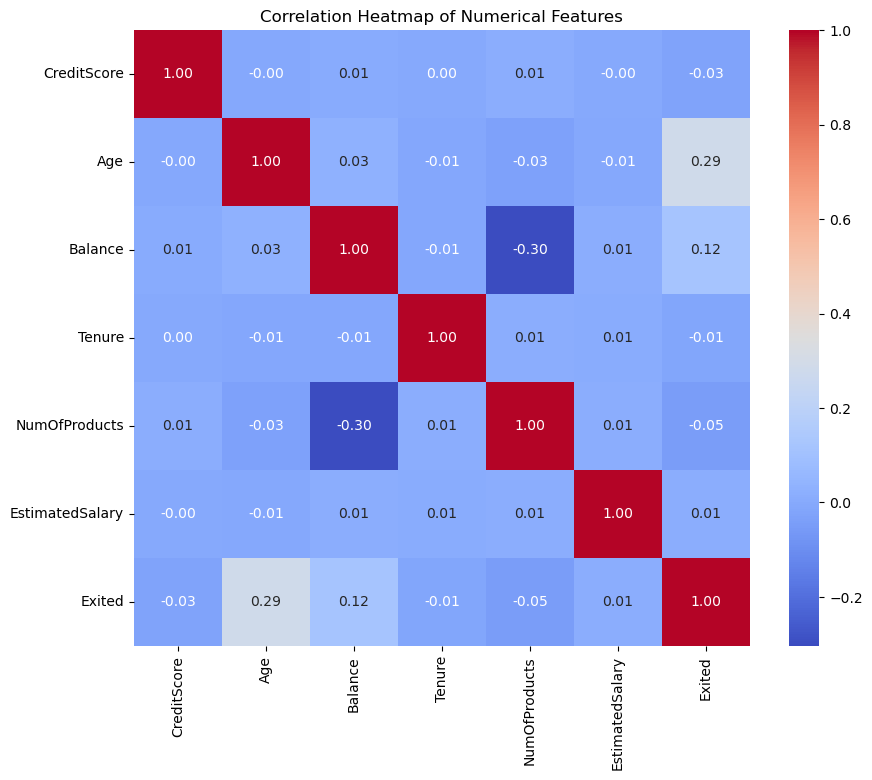

In [10]:
# Heatmap for numerical variables

num_col = ['CreditScore', 'Age', 'Balance', 'Tenure', 'NumOfProducts', 'EstimatedSalary', 'Exited']
df_num = df[num_col]

corr = df_num.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numerical Features")

**Insight**
1. Most features show little to no correlation with the target variable (Exited).
2. Only the Age feature shows a slight correlation with Exited, with a correlation coefficient of 0.29.

# Data Cleaning

### Outlier
Removed entries where age > 85 years.

In [11]:
df = df[df['Age'] <= 85]
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


# Define X and y

In [12]:
X = df.drop("Exited",axis=1)
y = df['Exited']

In [13]:
y.value_counts()

Exited
0    7960
1    2037
Name: count, dtype: int64

In [14]:
total = len(y)
perc_0 = (y.value_counts()[0] / total) * 100
perc_1 = (y.value_counts()[1] / total) * 100

print(f"Class 0 (Not Churn): {perc_0:.2f}%")
print(f"Class 1 (Churn): {perc_1:.2f}%")

Class 0 (Not Churn): 79.62%
Class 1 (Churn): 20.38%


The class distribution is imbalanced, with Class 0 (Not Churn) representing 79.62% of the data and Class 1 (Churn) only 20.38%. Given this imbalance, the F1 score was chosen as the evaluation metric, as it better reflects model performance on imbalanced datasets by balancing precision and recall.

# Data Splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0, 
    stratify=y)

# Preprocessing
To prepare the dataset for machine learning modeling, a series of preprocessing steps were applied to ensure that all features were appropriately encoded and scaled. 
1. Encode -> one hot
   - Geography
   - Gender
2. Scaling -> robust
   - Credit Score
   - Age
   - Tenure
   - Balance
   - Num of Products
   - Estimated Salary

### Column Transformer

In [16]:
transformer = ColumnTransformer([
    ('robust', RobustScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
    ('onehot', OneHotEncoder(drop='first'), ['Gender', 'Geography']),
    ("pass","passthrough",["HasCrCard", "IsActiveMember"])
], remainder = 'drop')

transformer

ColumnTransformer(transformers=[('robust', RobustScaler(),
                                 ['CreditScore', 'Age', 'Tenure', 'Balance',
                                  'NumOfProducts', 'EstimatedSalary']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['Gender', 'Geography']),
                                ('pass', 'passthrough',
                                 ['HasCrCard', 'IsActiveMember'])])

In [17]:
# fit to X_train
transformer.fit(X_train)

ColumnTransformer(transformers=[('robust', RobustScaler(),
                                 ['CreditScore', 'Age', 'Tenure', 'Balance',
                                  'NumOfProducts', 'EstimatedSalary']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['Gender', 'Geography']),
                                ('pass', 'passthrough',
                                 ['HasCrCard', 'IsActiveMember'])])

In [18]:
# Transform to X_train and X_test
X_train_prep = transformer.transform(X_train)
X_test_prep = transformer.transform(X_test)

In [19]:
# Preprocessing Result
df_X_train = pd.DataFrame(X_train_prep)
df_X_train

,0,1,2,3,4,5,6,7,8,9,10
0,-2.246269,1.666667,-0.2,0.510332,0.0,0.705746,0.0,1.0,0.0,1.0,0.0
1,-1.164179,0.583333,-1.0,0.637106,1.0,-0.997906,0.0,0.0,1.0,1.0,0.0
2,-1.111940,-0.416667,0.8,0.018533,1.0,0.586171,1.0,0.0,1.0,1.0,1.0
3,-1.276119,0.166667,-0.8,0.104329,0.0,0.239456,1.0,0.0,1.0,1.0,1.0
4,-1.694030,-1.250000,0.4,0.561193,1.0,0.365872,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7992,0.231343,-0.666667,-1.0,0.280060,0.0,-0.459702,1.0,0.0,1.0,1.0,0.0
7993,0.395522,0.333333,-0.2,-0.200530,1.0,0.428720,1.0,1.0,0.0,1.0,1.0
7994,0.955224,0.000000,-0.4,-0.765603,1.0,0.833852,0.0,0.0,0.0,0.0,0.0
7995,1.059701,0.333333,0.4,-0.765603,1.0,-0.268669,0.0,0.0,0.0,1.0,1.0


In [20]:
# Column names
col_names = transformer.get_feature_names_out()
col_names, len(col_names)

(array(['robust__CreditScore', 'robust__Age', 'robust__Tenure',
        'robust__Balance', 'robust__NumOfProducts',
        'robust__EstimatedSalary', 'onehot__Gender_Male',
        'onehot__Geography_Germany', 'onehot__Geography_Spain',
        'pass__HasCrCard', 'pass__IsActiveMember'], dtype=object),
 11)

In [21]:
df_X_train.columns = col_names
df_X_train

,robust__CreditScore,robust__Age,robust__Tenure,robust__Balance,robust__NumOfProducts,robust__EstimatedSalary,onehot__Gender_Male,onehot__Geography_Germany,onehot__Geography_Spain,pass__HasCrCard,pass__IsActiveMember
0,-2.246269,1.666667,-0.2,0.510332,0.0,0.705746,0.0,1.0,0.0,1.0,0.0
1,-1.164179,0.583333,-1.0,0.637106,1.0,-0.997906,0.0,0.0,1.0,1.0,0.0
2,-1.111940,-0.416667,0.8,0.018533,1.0,0.586171,1.0,0.0,1.0,1.0,1.0
3,-1.276119,0.166667,-0.8,0.104329,0.0,0.239456,1.0,0.0,1.0,1.0,1.0
4,-1.694030,-1.250000,0.4,0.561193,1.0,0.365872,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7992,0.231343,-0.666667,-1.0,0.280060,0.0,-0.459702,1.0,0.0,1.0,1.0,0.0
7993,0.395522,0.333333,-0.2,-0.200530,1.0,0.428720,1.0,1.0,0.0,1.0,1.0
7994,0.955224,0.000000,-0.4,-0.765603,1.0,0.833852,0.0,0.0,0.0,0.0,0.0
7995,1.059701,0.333333,0.4,-0.765603,1.0,-0.268669,0.0,0.0,0.0,1.0,1.0


# Modeling
To identify the most effective model for our classification task, we trained and evaluated three different algorithms.
1. Multiple Logistic Regression
2. K-Nearest Neighbors (KNN)
3. Decision Tree
4. Random forest
5. Stacking
6. Voting
7. Adaboost

# Pipeline

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [23]:
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(max_depth=5)
rf = RandomForestClassifier(random_state=42)
voting = VotingClassifier([
    ('voting_classifier1', logreg),
    ('voting_classifier2', knn),
    ('voting_classifier3', tree)
])
stacking = StackingClassifier(
    estimators=[
        ('stacking_classifier1', logreg),
        ('stacking_classifier2', knn),
        ('stacking_classifier3', tree)
    ],
    final_estimator= DecisionTreeClassifier(random_state=42),
    passthrough=False
)
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    random_state=42
)


model_list = [logreg, knn, tree, rf, voting, stacking, adaboost]

In [24]:
from sklearn.metrics import fbeta_score,make_scorer

In [25]:
f2 = make_scorer(fbeta_score, beta = 2)

In [26]:
result = []

for model in model_list:

    model_pipe = Pipeline([
        ("transformer", transformer),
        ("model", model)
    ])

    cv_score = cross_val_score(
        estimator = model_pipe,
        X = X_train,
        y = y_train,
        cv = 5,
        scoring = f2
    ).round(2)

    result.append({
        "algo" : model,
        "score": cv_score,
        "mean_f1" : cv_score.mean(),
        "std" : cv_score.std()
    })

In [27]:
result_df = pd.DataFrame(result)
result_df

,algo,score,mean_f1,std
0,LogisticRegression(random_state=42),"[0.24, 0.23, 0.28, 0.25, 0.23]",0.246,0.018547
1,KNeighborsClassifier(),"[0.42, 0.47, 0.43, 0.43, 0.42]",0.434,0.018547
2,DecisionTreeClassifier(max_depth=5),"[0.45, 0.54, 0.5, 0.44, 0.5]",0.486,0.036661
3,RandomForestClassifier(random_state=42),"[0.5, 0.51, 0.52, 0.47, 0.51]",0.502,0.017205
4,VotingClassifier(estimators=[('voting_classifi...,"[0.37, 0.42, 0.39, 0.39, 0.4]",0.394,0.016248
5,StackingClassifier(estimators=[('stacking_clas...,"[0.45, 0.54, 0.5, 0.49, 0.49]",0.494,0.028705
6,AdaBoostClassifier(estimator=DecisionTreeClass...,"[0.52, 0.49, 0.51, 0.47, 0.47]",0.492,0.020396


The best is Random Forest, but we will pick the top 2 model, which are Random Forest and AdaBoost because they achieved high mean f1 score with a relatively low standard deviation, indicating both strong performance and model stability.

## Base Model RandomForestClassifier

In [28]:
# Define Model
rf_1 = RandomForestClassifier()

# Fit
rf_1.fit(X_train_prep, y_train)

RandomForestClassifier()

# Hyperparameter Tunning RandomForestClassifier

In [29]:
# Hyperparameter
hyper_param = {
    'model__n_estimators': [10,20,50,100],
    'model__max_depth': [1,3,5,7],
    "model__min_samples_split": [1,5,9],
    "model__min_samples_leaf": [1,5,9]
}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('model', rf_1)
])

# Grid Search
grid_rf = GridSearchCV(
    estimator = pipe_model,
    param_grid = hyper_param,
    cv= 5,
    scoring = f2,
    return_train_score=True,
    n_jobs= -1
)

In [30]:
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Gender',
                                                                          'Geography']),
                                                                        ('pass',
                                                                         'passthrough',
                                                                         ['HasCrCard',
                                                                          'IsActiveMember'])])),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [1, 3, 5, 7],
                         'model__min_samples_leaf': [1, 5, 9],
                         'model__min_samples_split': [1, 5, 9],
                         'model__n_estimators': [10, 20, 50, 100]},
             return_train_score=True,
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [31]:
gs_rf_result = pd.DataFrame(grid_rf.cv_results_)
gs_rf_result = gs_rf_result[["params","mean_train_score","std_train_score","mean_test_score","std_test_score"]].sort_values("mean_test_score",ascending=False)
gs_rf_result.head()

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
139,"{'model__max_depth': 7, 'model__min_samples_le...",0.500322,0.011431,0.463678,0.020580
142,"{'model__max_depth': 7, 'model__min_samples_le...",0.493668,0.013682,0.463122,0.024787
118,"{'model__max_depth': 7, 'model__min_samples_le...",0.500458,0.011892,0.462828,0.012677
131,"{'model__max_depth': 7, 'model__min_samples_le...",0.496849,0.009988,0.461060,0.019619
143,"{'model__max_depth': 7, 'model__min_samples_le...",0.491316,0.015372,0.460958,0.020108


In [32]:
grid_rf.best_params_

{'model__max_depth': 7,
 'model__min_samples_leaf': 9,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

In [33]:
rf_2 = grid_rf.best_estimator_
rf_2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=9,
                                        min_samples_split=5))])

In [34]:
rf_2.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=9,
                                        min_samples_split=5))])

In [35]:
rf_1 = Pipeline([
    ('preprocessing', transformer),
    ('model', rf_1)
])

In [36]:
rf_1.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model', RandomForestClassifier())])

In [37]:
y_pred_rf_1 = rf_1.predict(X_test)
y_pred_rf_1

array([0, 0, 0, ..., 0, 1, 0], shape=(2000,))

In [38]:
y_pred_rf_2 = rf_2.predict(X_test)
y_pred_rf_2

array([0, 0, 0, ..., 0, 0, 0], shape=(2000,))

## Base Model AdaBoost (Decision Tree)

In [39]:
# Define Model
adaboost_1 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    random_state=42
)

# Fit
adaboost_1.fit(X_train_prep, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

# Hyperparameter Tunning Adaboost

In [40]:
from sklearn.linear_model import RidgeClassifier

In [ ]:
# Hyperparameter
hyper_param = {'model__estimator': [logreg, tree, RidgeClassifier()],
               'model__n_estimators': [10,20,50,100],
               'model__learning_rate': [1.0,0.1,0.01]
}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('model', adaboost_1)
])

# Grid Search
grid_search = GridSearchCV(
    estimator = pipe_model,
    param_grid = hyper_param,
    cv= 5,
    scoring = f2,
    return_train_score=True,
    n_jobs= -1
)

In [42]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Gender',
                                                                          'Geography']),
                                                                        ('pass',
                                                                         'passthrough',
                                                                         ['HasCrCard',
                                                                          'IsActiveMember'])])),
                                       ('model',
                                        AdaBoostClassifier(estimator...ionTreeClassifier(max_depth=1),
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__estimator': [LogisticRegression(random_state=42),
                                              DecisionTreeClassifier(max_depth=5),
                                              RidgeClassifier()],
                         'model__learning_rate': [1.0, 0.1, 0.01],
                         'model__n_estimators': [10, 20, 50, 100]},
             return_train_score=True,
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [43]:
gs_result = pd.DataFrame(grid_search.cv_results_)
gs_result = gs_result[["params","mean_train_score","std_train_score","mean_test_score","std_test_score"]].sort_values("mean_test_score",ascending=False)

In [44]:
gs_result.head()

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
14,{'model__estimator': DecisionTreeClassifier(ma...,0.661519,0.016063,0.535644,0.016713
15,{'model__estimator': DecisionTreeClassifier(ma...,0.699169,0.024933,0.528842,0.019433
13,{'model__estimator': DecisionTreeClassifier(ma...,0.597157,0.017523,0.526764,0.024808
12,{'model__estimator': DecisionTreeClassifier(ma...,0.577966,0.010655,0.519875,0.025350
19,{'model__estimator': DecisionTreeClassifier(ma...,0.530653,0.012466,0.509137,0.017248


In [45]:
grid_search.best_params_

{'model__estimator': DecisionTreeClassifier(max_depth=5),
 'model__learning_rate': 1.0,
 'model__n_estimators': 50}

In [46]:
adaboost_2 = grid_search.best_estimator_
adaboost_2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                    random_state=42))])

In [47]:
adaboost_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                    random_state=42))])

In [48]:
adaboost_1 = Pipeline([
    ('preprocessing', transformer),
    ('model', adaboost_1)
])

In [49]:
adaboost_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    random_state=42))])

In [50]:
# Predict (adaboost_1)
y_pred_adaboost_1 = adaboost_1.predict(X_test)
y_pred_adaboost_1

array([0, 0, 0, ..., 0, 0, 0], shape=(2000,))

In [51]:
# Predict (adaboost_2)
y_pred_adaboost_2 = adaboost_2.predict(X_test)
y_pred_adaboost_2


array([0, 0, 0, ..., 0, 1, 0], shape=(2000,))

# Evaluation

In [52]:
rf_1_score = fbeta_score(y_test, y_pred_rf_1,beta=2)
rf_1_score

0.49438802779262425

In [53]:
rf_2_score = fbeta_score(y_test, y_pred_rf_2, beta=2)
rf_2_score

0.430987452264048

In [54]:
adaboost_1_score = fbeta_score(y_test, y_pred_adaboost_1, beta=2)
adaboost_1_score

0.4294149221685454

In [55]:
adaboost_2_score = fbeta_score(y_test, y_pred_adaboost_2, beta = 2)
adaboost_2_score

0.511482254697286

In [56]:
score_dict = {
    "type" : ["rf_1", "rf_2","adaboost_1","adaboost_2"],
    "f1_score": [rf_1_score,rf_2_score,adaboost_1_score,adaboost_2_score]
} 

In [57]:
score_df= pd.DataFrame(score_dict)
score_df

,type,f1_score
0,rf_1,0.494388
1,rf_2,0.430987
2,adaboost_1,0.429415
3,adaboost_2,0.511482


**Insight**\
The F1 score of the model RandomForestClassifier without hyperparameter tuning is 0.57. After applying hyperparameter tuning, it's F1-score decrease to 0.51.

The F1 score of the model Adaboost without hyperparameter tuning is 0.50. After applying hyperparameter tuning, it's F1-score increase to 0.56.

# Tunning Data and Hyperparameter

In [58]:
gs_result.head()

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
14,{'model__estimator': DecisionTreeClassifier(ma...,0.661519,0.016063,0.535644,0.016713
15,{'model__estimator': DecisionTreeClassifier(ma...,0.699169,0.024933,0.528842,0.019433
13,{'model__estimator': DecisionTreeClassifier(ma...,0.597157,0.017523,0.526764,0.024808
12,{'model__estimator': DecisionTreeClassifier(ma...,0.577966,0.010655,0.519875,0.025350
19,{'model__estimator': DecisionTreeClassifier(ma...,0.530653,0.012466,0.509137,0.017248


Since our best-performing model shows no indication of overfitting, we proceeded to explore two additional feature engineering techniques to potentially enhance model performance:
- Binning : CreditScore, Age, Balance, EstimatedSalary
- polynomialfeature : Creditscore, Age, Balance, EstimatedSalary

In [75]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV

In [66]:
smote = SMOTE(random_state = 0)
nearmiss = NearMiss()
rus = RandomUnderSampler(random_state = 0)
ros = RandomOverSampler(random_state = 0)
resampler= [smote, rus, ros, None]

In [61]:
# Pipeline
pipeline_binning = Pipeline([
    ("bin" , KBinsDiscretizer())
])

pipeline_poly = Pipeline([
    ("poly",PolynomialFeatures()),
    ("scale", RobustScaler())
])

In [62]:
# Transformer Bin
transformer = ColumnTransformer([
    ("num" , pipeline_binning, ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']),
    ('robust', RobustScaler(), ['Tenure','NumOfProducts']),
    ('onehot', OneHotEncoder(drop='first'), ['Gender', 'Geography']),
    ("pass","passthrough",["HasCrCard", "IsActiveMember"])
], remainder = 'drop')

In [71]:
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    random_state=42
)
# Full Pipeline
pipe_model = Pipeline([
    ("preprocessing", transformer),
    ("resampler", smote),
    ("model", adaboost)
])

In [72]:
# Define Parameter for Gridsearch
param_grid = [
    # binning
    {
        "preprocessing__num": [pipeline_binning],
        "preprocessing__num__bin__strategy" : ["quantile"],
        "preprocessing__num__bin__n_bins": [5, 10],
        "resampler": resampler,
        'model__estimator': [logreg, tree, RidgeClassifier()],
        'model__n_estimators': [10,20,50,100],
        'model__learning_rate': [1.0,0.1,0.01]
    },

    # polynomialfeature
    {
        "preprocessing__num": [pipeline_poly],
        "preprocessing__num__poly__degree" : [2,3],
        "resampler": resampler,
        'model__estimator': [logreg, tree, RidgeClassifier()],
        'model__n_estimators': [10,20,50,100],
        'model__learning_rate': [1.0,0.1,0.01]
    }
]

In [77]:
rs = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=param_grid,
    cv=5,
    scoring=f2,
    return_train_score=True,
    n_jobs= -1,
    n_iter = 100
)

In [78]:
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('bin',
                                                                                                KBinsDiscretizer())]),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Balance',
                                                                                'EstimatedSalary']),
                                                                              ('robust',
                                                                               RobustScaler(),
                                                                               ['Tenure',
                                                                                'NumOfProducts']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Gender',
                                                                                'Geography']),
                                                                              ('pass',
                                                                               'passthrough',
                                                                               ['HasCrCard...
                                         'model__n_estimators': [10, 20, 50,
                                                                 100],
                                         'preprocessing__num': [Pipeline(steps=[('poly',
                                                                                 PolynomialFeatures()),
                                                                                ('scale',
                                                                                 RobustScaler())])],
                                         'preprocessing__num__poly__degree': [2,
                                                                              3],
                                         'resampler': [SMOTE(random_state=0),
                                                       RandomUnderSampler(random_state=0),
                                                       RandomOverSampler(random_state=0),
                                                       None]}],
                   return_train_score=True,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [79]:
rs_tuned_result = pd.DataFrame(rs.cv_results_)
rs_tuned_result = rs_tuned_result[["params","mean_train_score","std_train_score","mean_test_score","std_test_score"]].sort_values("mean_test_score",ascending=False)

In [80]:
rs_tuned_result.head()

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
57,{'resampler': RandomUnderSampler(random_state=...,0.713163,0.008155,0.676439,0.015813
94,{'resampler': RandomUnderSampler(random_state=...,0.701659,0.007372,0.673206,0.018558
73,{'resampler': RandomOverSampler(random_state=0...,0.712560,0.003425,0.672347,0.018697
89,{'resampler': RandomUnderSampler(random_state=...,0.697676,0.004825,0.671824,0.019229
70,{'resampler': RandomOverSampler(random_state=0...,0.713902,0.004259,0.669908,0.016097


In [81]:
rs.best_params_

{'resampler': RandomUnderSampler(random_state=0),
 'preprocessing__num__poly__degree': 2,
 'preprocessing__num': Pipeline(steps=[('poly', PolynomialFeatures()), ('scale', RobustScaler())]),
 'model__n_estimators': 100,
 'model__learning_rate': 0.1,
 'model__estimator': DecisionTreeClassifier(max_depth=5)}

In [82]:
adaboost_tuned_model = rs.best_estimator_
adaboost_tuned_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['Tenure', 'NumOfProducts']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Geography']),
                                                 ('pass', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('resampler', RandomUnderSampler(random_state=0)),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                    learning_rate=0.1, n_estimators=100,
                                    random_state=42))])

# Evaluation

In [83]:
y_tuned_adaboost_pred = adaboost_tuned_model.predict(X_test)
y_tuned_adaboost_pred

array([0, 0, 0, ..., 0, 1, 0], shape=(2000,))

In [84]:
fbeta_score(y_test, y_tuned_adaboost_pred, beta=2)

0.6538289296909987

In [90]:
score_df.loc[len(score_df)] = ["adaboost_tuned", fbeta_score(y_test,y_tuned_adaboost_pred,beta=2)]

In [91]:
score_df

,type,f1_score
0,rf_1,0.494388
1,rf_2,0.430987
2,adaboost_1,0.429415
3,adaboost_2,0.511482
4,adaboost_tuned,0.578791
5,adaboost_tuned,0.653829


Insight:
- The fully tuned model (with polynomial), had lower F1 score of 0.50.
- The best model is the base RandomForestClassifier model without additional preprocessing, as it achieved the highest F1 score of 0.5853.

# Threshold Tuning

predict probability

In [95]:
y_pred_proba= adaboost_tuned_model.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.42349121, 0.31783015, 0.40714723, ..., 0.20647902, 0.80923092,
       0.26632731], shape=(2000,))

tuning threshold

In [96]:
list_threshold = np.arange(0.01, 1.00, 0.01)
list_f2 = []

for threshold in list_threshold:
    y_pred_class = np.where(y_pred_proba > threshold, 1, 0)
    score = fbeta_score(y_test, y_pred_class, beta = 2)
    list_f2.append(score)


df_threshold = pd.DataFrame()
df_threshold['Threshold'] = list_threshold
df_threshold['F2 Score'] = list_f2

df_threshold.sort_values(by = 'F2 Score', ascending = False)

,Threshold,F2 Score
42,0.43,0.693750
37,0.38,0.693416
35,0.36,0.691026
44,0.45,0.690171
36,0.37,0.689324
...,...,...
94,0.95,0.000000
95,0.96,0.000000
96,0.97,0.000000
97,0.98,0.000000


visualisasi

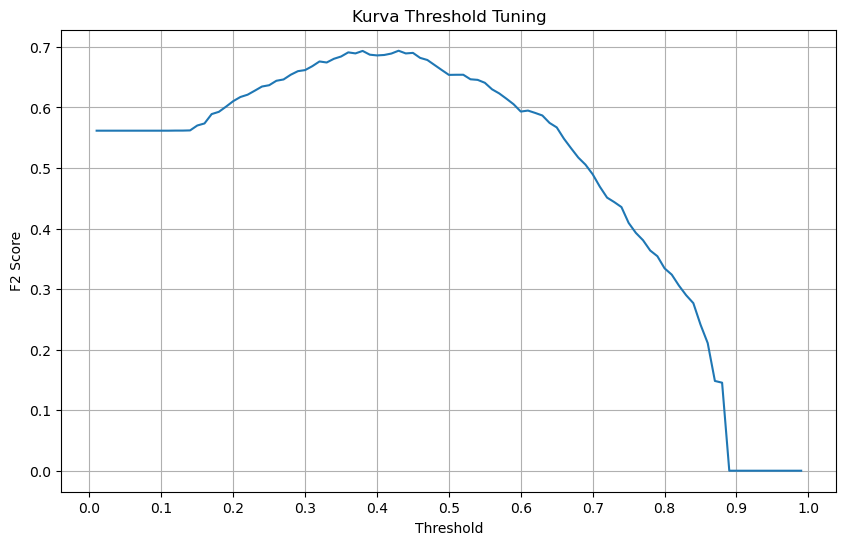

In [97]:
plt.figure(figsize= (10,6))
sns.lineplot(data = df_threshold, x = 'Threshold', y = 'F2 Score')
plt.title('Kurva Threshold Tuning')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1));

## Confusion Matrix

In [99]:
y_tuned_adaboost_pred_proba = adaboost_tuned_model.predict_proba(X_test)[:, 1]
y_tuned_adaboost_pred_proba

array([0.42349121, 0.31783015, 0.40714723, ..., 0.20647902, 0.80923092,
       0.26632731], shape=(2000,))

In [100]:
y_tuned_adaboost_pred = np.where(y_tuned_adaboost_pred_proba > 0.43, 1, 0)
y_tuned_adaboost_pred

array([0, 0, 0, ..., 0, 1, 0], shape=(2000,))

In [101]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_tuned_adaboost_pred)
cm

array([[1157,  435],
       [  75,  333]])

<Axes: >

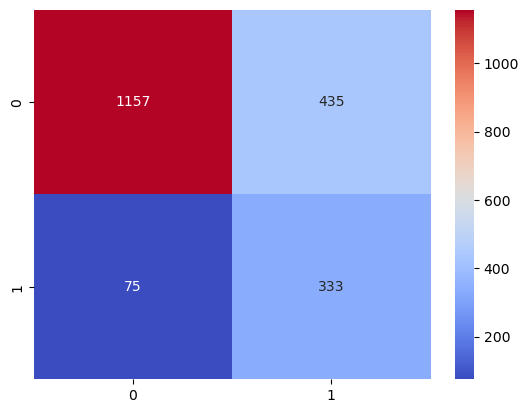

In [102]:
sns.heatmap(cm, annot=True, fmt=".0f", cmap='coolwarm')

## Insight
1. Cost Analysis Before Implementing Machine Learning for Churn Prediction
Before the implementation of any machine learning model to predict customer churn, two scenarios can be considered to illustrate the potential financial consequences of misclassifying customers.

- Scenario 1: Assuming All Customers Will Churn
    In this scenario, the bank assumes that every customer is at risk of churning. As a result, retention efforts are applied to all customers, including those who would not have churned in the first place. This leads to unnecessary retention costs for customers who would have remained loyal without intervention.

    Retention cost per customer: USD 20

    Total number of customers: 1,157 + 435 = 1,592

    Total cost: 31,840 USD

- ​Scenario 2: Assuming All Customers Will Stay
    In this alternative scenario, the bank assumes no customer will churn. As a consequence, no retention actions are taken, and all customers who would actually churn are lost. The bank will need to acquire new customers to replace the lost ones, incurring acquisition costs.

    Acquisition cost per customer: USD 100

    Total number of churning customers: 75 + 333 = 408

    Total cost: 40,800 USD

2. Cost Analysis After Implementing Machine Learning for Churn Prediction
With the help of a machine learning model (e.g., Random Forest), the company can more accurately identify churn and focus retention only on high-risk customers.

- True Positives (435): Predicted to churn and actually churned → Apply retention (20 USD × 435 = 8,700 USD)

- False Negatives (75): Predicted to stay but actually churned → Need reacquisition (100 USD × 75 = 7,500 USD)

- Total cost with ML model:
adaboost_cost = (435 × 20) + (75 × 100) = 8,700 USD + 7,500 USD = 16,200 USD


# Summary
Machine learning significantly reduces the total cost of managing customer churn. By focusing retention efforts only on customers who are truly at risk:
- Costs drop from 31,840 USD/40,800 USD to 16,200 USD so machine learning significantly reduces both false assumptions and associated costs compared to the two scenarios presented earlier
- The company becomes more efficient and targeted in its decision-making
- Machine learning provides a data-driven, cost-effective, and strategic approach compared to traditional assumption-based methods.